## Example: Single Index Models and MinVar Portfolio Allocation
Fill me in

## Setup

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-Examples-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`


## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `11-03-2023`, along with data for a few exchange traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `load(...)` method exported by the [JLD2.jl](https://github.com/JuliaIO/JLD2.jl.git) package:

In [2]:
original_dataset = load(joinpath(_PATH_TO_DATA, "SP500-Daily-OHLC-1-3-2018-to-11-03-2023.jld2")) |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of tradition days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

In [4]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Let's get a list of firms that we have in cleaned up `dataset`, and save it ib the `all_tickers` array

In [5]:
all_tickers = keys(dataset) |> collect |> sort;

Finally, let's set some constant values

In [6]:
risk_free_rate = 0.05;

### Compute the covariance and expected yield for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll provide values for both of these items for the entire data set (all `N = 459` tickers), and then you can pick out which tickers you are interested in. 

* First, we compute the expected (annualized) log return by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the `log_return_matrix(...)` method. The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time-value, while each column corresponds to a firm:

In [7]:
all_firms_excess_return_matrix = log_return_matrix(dataset, all_tickers, 
    Δt = (1.0/252.0), risk_free_rate = risk_free_rate);

Next, we estimate the expected excess return for each firm from the `all_firms_excess_return_matrix` using the `mean(...)` function, which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(R_{1}),\dotsc,\mathbb{E}(R_{N})$ in the variable $\mu$:

In [8]:
μ = mean(all_firms_excess_return_matrix, dims=1) |> vec;

Finally, we estimate the annualized `covariance_matrix` from the `all_firms_return_matrix` using the `cov(...)` function, exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ covariance matrix in the $\Sigma$ variable:

In [9]:
Σ = cov(all_firms_excess_return_matrix) |> x-> x*(1/252); # annualized, historical volatility

### Build single index model returns and covariance

In [10]:
sims = load(joinpath(_PATH_TO_DATA, "SIM-SP500-01-03-18-to-10-31-23.jld2")) |> x->x["sim"]

Dict{String, MySingleIndexModel} with 459 entries:
  "NI"   => MySingleIndexModel(-0.0667694, 0.650089, 0.05, Normal{Float64}(μ=4.…
  "EMR"  => MySingleIndexModel(-0.0420337, 1.23606, 0.05, Normal{Float64}(μ=8.6…
  "CTAS" => MySingleIndexModel(0.121342, 1.18426, 0.05, Normal{Float64}(μ=-3.75…
  "HSIC" => MySingleIndexModel(-0.0887318, 0.918814, 0.05, Normal{Float64}(μ=7.…
  "KIM"  => MySingleIndexModel(-0.0834768, 1.28034, 0.05, Normal{Float64}(μ=-1.…
  "PLD"  => MySingleIndexModel(0.00268562, 1.01582, 0.05, Normal{Float64}(μ=7.3…
  "IEX"  => MySingleIndexModel(-0.00997753, 0.962278, 0.05, Normal{Float64}(μ=3…
  "BAC"  => MySingleIndexModel(-0.105029, 1.31866, 0.05, Normal{Float64}(μ=-1.6…
  "CBOE" => MySingleIndexModel(-0.0157717, 0.594397, 0.05, Normal{Float64}(μ=-3…
  "EXR"  => MySingleIndexModel(-0.0361987, 0.709725, 0.05, Normal{Float64}(μ=1.…
  "NCLH" => MySingleIndexModel(-0.349225, 2.33008, 0.05, Normal{Float64}(μ=3.66…
  "CVS"  => MySingleIndexModel(-0.0803743, 0.78294, 0.05, 

In [11]:
index_SPY = findfirst(x->x=="SPY", all_tickers);
R_SPY = μ[index_SPY];

In [12]:
μ_sim = Array{Float64,1}();
for i ∈ eachindex(all_tickers)
    
    myticker = all_tickers[i];
    sim = sims[myticker];
    
    αᵢ = sim.α
    βᵢ = sim.β
    Rᵢ = αᵢ+βᵢ*R_SPY
    
    push!(μ_sim,Rᵢ)
end

Now let's build the `single index model` version of the covariance array. Substituting the single index model for the excess return of asset $i$ and $j$ into the covariance expression (and simplifing) gives:

$$
\begin{equation*}
\text{cov}(R_{i}, R_{j}) = \begin{cases}
\beta_{i}^{2}\sigma_{m}^{2}+\sigma_{\epsilon_{i}}^{2} & i = j \\
\beta_{i}\beta_{j}\sigma_{m}^2 & i \neq j
\end{cases}
\end{equation*}
$$

where $\sigma_{m}^2$ denotes the variance of the excess return of the market, 
and $\sigma_{\epsilon_{i}}^{2}$ denotes the variance of the firm-specific error model.

In [13]:
d = fit_mle(Laplace, all_firms_excess_return_matrix[:,index_SPY]);
σₘ = params(d)[2]

1.7683675703910142

In [14]:
Σ_tmp = Array{Float64,2}(undef, length(μ), length(μ));
for i ∈ eachindex(all_tickers)
    outer_ticker = all_tickers[i];
    sim_outer = sims[outer_ticker];
    
    for j ∈ eachindex(all_tickers)
        
        inner_ticker = all_tickers[j];
        sim_inner = sims[inner_ticker];
        
        if (i == j)
            βᵢ = sim_outer.β
            ϵᵢ = sim_outer.ϵ
            σ_ϵᵢ = params(ϵᵢ)[2];
            Σ_tmp[i,j] = ((βᵢ)^2)*((σₘ)^2)+(σ_ϵᵢ)^2
        else
            βᵢ = sim_outer.β
            βⱼ = sim_inner.β
            Σ_tmp[i,j] = βᵢ*βⱼ*(σₘ)^2
        end
    end
end

In [15]:
Σ_sim  = Σ_tmp |> x-> x*(1/252)

459×459 Matrix{Float64}:
 0.0496953   0.0231973  0.0130127   …  0.0186486   0.017709   0.0138832
 0.0231973   0.247491   0.0213871      0.0306499   0.0291056  0.0228178
 0.0130127   0.0213871  0.108614       0.0171934   0.0163271  0.0127999
 0.016469    0.0270676  0.0151838      0.02176     0.0206636  0.0161995
 0.00944056  0.015516   0.00870388     0.0124735   0.0118451  0.00928612
 0.0110562   0.0181715  0.0101935   …  0.0146083   0.0138723  0.0108754
 0.0160447   0.0263703  0.0147927      0.0211994   0.0201313  0.0157822
 0.0166904   0.0274315  0.015388       0.0220525   0.0209414  0.0164173
 0.0163324   0.0268432  0.015058       0.0215796   0.0204923  0.0160652
 0.0109434   0.0179861  0.0100895      0.0144592   0.0137307  0.0107644
 0.0135242   0.0222277  0.0124689   …  0.0178691   0.0169688  0.0133029
 0.0195281   0.0320955  0.0180043      0.0258019   0.0245019  0.0192086
 0.00820333  0.0134826  0.0075632      0.0108388   0.0102927  0.00806913
 ⋮                                  ⋱

## Task 1: Build the log return array and covariance matrix
Before we compute the efficient frontier, we must decide which stocks to include in the risky portfolio. One strategy is to pick stocks that have small or even negative covariance. Let's explore this idea. 

* Specify a collection of `ticker symbols`, e.g., `AAPL`, `MSFT`, etc., that interest you in the `my_list_of_tickers` array. We'll  put the indexes of your tickers in the `my_list_of_firm_ids` array:

In [16]:
my_list_of_tickers = ["AAPL", "INTC", "MSFT", "MU", "AMD", "GS", "BAC", "WFC", "C", "F"];
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids, firm_index)
end

Now that you have selected the firms in your risky portfolio, we'll compute for you the firm-specific expected return vector and covariance matrix. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. First, we'll construct the $\hat{\mu}$ vector for the `data` and `single index model` versions of the problem:

In [17]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂ = Array{Float64,1}();
μ̂_sim = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂, μ[firm_index])
    push!(μ̂_sim, μ_sim[firm_index])
end
# ---------------------------------------------------------------------- #

and then we'll compute the firm-specific covariance $\hat{\Sigma}$ matrix for the `data` version of the problem:

In [18]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂[i,j] = Σ[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

and then the `single index model` version of the problem:

In [19]:
# --- DO NOT CHANGE THIS BLOCK FOR SIM  -------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂_sim = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂_sim[i,j] = Σ_sim[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

## Task 2: Compute the efficient frontier for your collection of stocks
Create an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, and store this in the `problem_risk` variable using the `build(...)` method. You'll need to pass your covariance array $\hat{\Sigma}$, the expected return array $\hat{\mu}$, along with bounds and an initial guess, to the `build(...)` method. 

Let's setup the bounds, and some other constants:

In [20]:
number_of_firms = length(my_list_of_tickers);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
risk_free_rate = 0.05;
number_of_points = 40;

and the build an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, using the `build(...)` method. Save the `data` version of the problem in the `problem_risk` variable:

In [21]:
problem_risk = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

and the `single index model` version of the problem in the `problem_risk_sim` variable:

In [22]:
problem_risk_sim = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂_sim,
    μ = μ̂_sim,
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Next, we create an array with the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable:

In [23]:
minimum_desired_reward_array = range(0.0, stop = 0.5 - risk_free_rate, length = number_of_points) |> collect;

Finally, we iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for-loop`. In particular, for each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward
* We then pass the updated `problem` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `frontier` dictionary.

In [24]:
efficient_frontier = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk.R = minimum_desired_reward_array[i];
    
    # compute -
    solution = solve(problem_risk)

    # check: did this converge?
    status_flag = solution["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution["objective_value"]);
        value = solution["reward"];
        efficient_frontier[key] = value;
    end
end
efficient_frontier

Dict{Float64, Float64} with 30 entries:
  0.221234 => 0.173077
  0.230462 => 0.196154
  0.207576 => 0.0824187
  0.225514 => 0.184615
  0.207576 => 0.0824187
  0.335592 => 0.276923
  0.208297 => 0.103846
  0.40753  => 0.311538
  0.207576 => 0.0824196
  0.217662 => 0.161538
  0.459585 => 0.334615
  0.207576 => 0.0824187
  0.259737 => 0.230769
  0.210701 => 0.126923
  0.358575 => 0.288462
  0.207576 => 0.0824187
  0.236809 => 0.207692
  0.207576 => 0.0824187
  0.246654 => 0.219231
  0.293788 => 0.253846
  0.209291 => 0.115385
  0.313901 => 0.265385
  0.382616 => 0.3
  0.207576 => 0.0824187
  0.275598 => 0.242308
  ⋮        => ⋮

Let's now do the single index model case:

In [25]:
efficient_frontier_sim = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_sim.R = minimum_desired_reward_array[i];
    
    # compute -
    solution_sim = solve(problem_risk_sim)

    # check: did this converge?
    status_flag = solution_sim["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution_sim["objective_value"]);
        value = solution_sim["reward"];
        efficient_frontier_sim[key] = value;
    end
end
efficient_frontier_sim

Dict{Float64, Float64} with 29 entries:
  0.165347 => 0.161538
  0.26755  => 0.265385
  0.158944 => 0.115385
  0.170103 => 0.184615
  0.176811 => 0.207692
  0.156242 => 0.0583033
  0.157966 => 0.103846
  0.173033 => 0.196154
  0.200428 => 0.230769
  0.157223 => 0.0923078
  0.156685 => 0.0807694
  0.163381 => 0.15
  0.15635  => 0.0692308
  0.185778 => 0.219231
  0.242293 => 0.253846
  0.353061 => 0.3
  0.156242 => 0.0583033
  0.156242 => 0.0583177
  0.156242 => 0.0583033
  0.294731 => 0.276923
  0.161654 => 0.138462
  0.156242 => 0.0583032
  0.160172 => 0.126923
  0.323351 => 0.288462
  0.383608 => 0.311538
  ⋮        => ⋮

### Visualize the Efficient Frontiers for the data and single index model

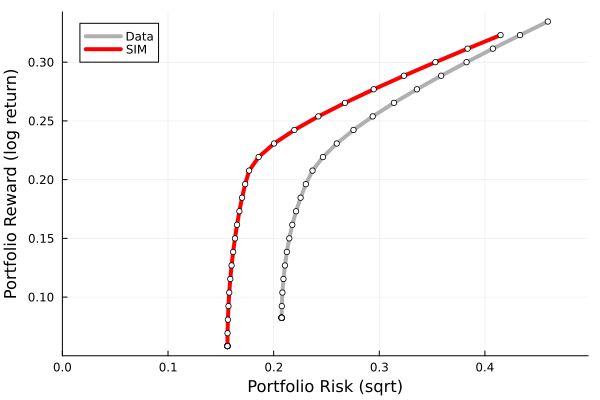

In [26]:
# regular -
plot(efficient_frontier, lw=4, xlabel="Portfolio Risk (sqrt)", 
    ylabel="Portfolio Reward (log return)", fontsize=18, c=:gray69, 
    xlim=(0.0, 1.2*maximum(efficient_frontier).first), label="Data")
scatter!(efficient_frontier, label="", c=:white, mec=:black, ms=3)

# single index model -
plot!(efficient_frontier_sim, lw=4, xlabel="Portfolio Risk (sqrt)", 
    ylabel="Portfolio Reward (log return)", fontsize=18, label="SIM", c=:red, 
    xlim=(0.0, 1.2*maximum(efficient_frontier_sim).first))
scatter!(efficient_frontier_sim, label="", c=:white, mec=:red, ms=3)

### Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.